In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd


EI_df = pd.read_csv('./MBTI_SN.csv')
#PJ_df = pd.read_csv('/content/drive/MyDrive/4-1/인공신경망과 딥러닝/팀플/dataset/MBTI_PJ.csv')
#SN_df = pd.read_csv('/content/drive/MyDrive/4-1/인공신경망과 딥러닝/팀플/dataset/MBTI_SN.csv')
#TF_df = pd.read_csv('/content/drive/MyDrive/4-1/인공신경망과 딥러닝/팀플/dataset/MBTI_TF.csv')
EI_df.head(10)


SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [8]:
from sklearn.model_selection import train_test_split

value_list=[]
for i in EI_df.wordvalue:
    ss=i.strip("'[").strip("]'").split(", ")
    sss=[]
    for j in ss:
        sss.append(int(j))
    value_list.append(sss)

X = torch.tensor(value_list)
y = torch.tensor(EI_df['type'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42)

Text(0.5, 1.0, 'Count of types')

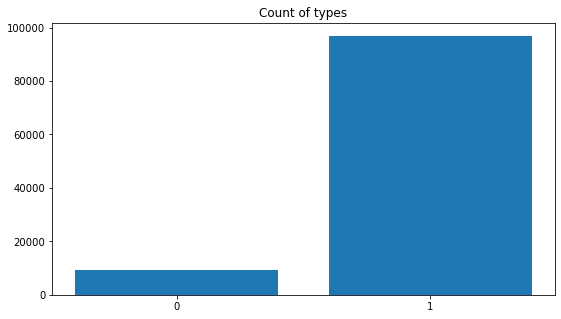

In [9]:
import numpy as np
import matplotlib.pyplot as plt

unique_labels, count = np.unique(EI_df['type'], return_counts=True)
fig = plt.figure(figsize=(9,5))
plt.xticks(np.arange(0,2,1))
plt.bar(unique_labels, count, width=0.8)
plt.title("Count of types")

In [10]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,  shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,  shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=int(X_test.size()[0]/10),  shuffle=True)

In [11]:
class GRU(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim,dropout_p):
        super(GRU, self).__init__()
        self.n_layers = 1
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embedding_dim, hidden_dim,
                          batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.embedding(x)

        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화

        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)

        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        self.dropout(h_t)
        logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return self.sigmoid(logit)

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


In [20]:
INPUT_DIM = 3771 
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT_PROB = 0.2

model = GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT_PROB)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)



In [18]:
loss_list = []
def binary_accuracy(preds, y):

  rounded_preds = torch.round(torch.sigmoid(preds))
  # rounded_preds : [batch size]
  # y : batch.label
  correct = (rounded_preds == y).float() ## 여기 argmax 바꼈습니다
  acc = correct.sum() / len(correct)
  return acc

def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch
        optimizer.zero_grad()
        y = y.squeeze(0)
        logit = model(x)
        y = y.unsqueeze(1)
        #loss = F.cross_entropy(logit, y)
        loss = F.binary_cross_entropy(logit,y.float())
        loss.backward()
        if(b%100==0):
          print("batch-", b, " loss-" , loss.item())
          loss_list.append(loss)
        optimizer.step()


def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch
        y = y.squeeze(0)
        logit = model(x)
        y = y.unsqueeze(1)
        #loss = F.cross_entropy(logit, y, reduction='sum')
        loss = F.binary_cross_entropy(logit,y.float())
        total_loss += loss.item()
        corrects +=  binary_accuracy(logit, y.float())
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [21]:
import time
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

best_val_loss = None
for e in range(1, 6):

    start_time = time.time()
    

    train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluate(model, val_dataloader)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))
    print(f'Epoch: {e:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')

    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

best_valid_loss = float('inf')

batch- 0  loss- 0.6681513786315918
batch- 100  loss- 0.34557855129241943
batch- 200  loss- 0.24776770174503326
batch- 300  loss- 0.31139108538627625
batch- 400  loss- 0.3586185574531555
batch- 500  loss- 0.18805338442325592
batch- 600  loss- 0.20450712740421295
batch- 700  loss- 0.20219655334949493
batch- 800  loss- 0.17784422636032104
batch- 900  loss- 0.08412208408117294
[Epoch: 1] val loss :  0.00 | val accuracy :  1.43
Epoch: 01 | Epoch Time: 32m 1s
batch- 0  loss- 0.10250893980264664
batch- 100  loss- 0.09967225044965744
batch- 200  loss- 0.1628405600786209
batch- 300  loss- 0.1339872032403946
batch- 400  loss- 0.12759986519813538
batch- 500  loss- 0.05510621517896652
batch- 600  loss- 0.1278878003358841
batch- 700  loss- 0.2563250660896301
batch- 800  loss- 0.2457009106874466
batch- 900  loss- 0.15235097706317902
[Epoch: 2] val loss :  0.00 | val accuracy :  1.43
Epoch: 02 | Epoch Time: 22m 10s
batch- 0  loss- 0.04117222875356674
batch- 100  loss- 0.0812910720705986
batch- 200  l

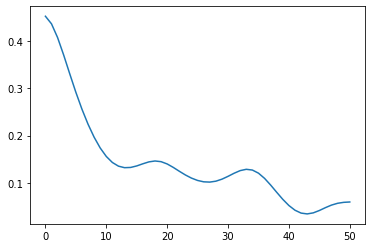

In [30]:
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
a = []
for i in loss_list:
    a.append(i.detach().numpy())
a = np.array(a)
a = a.astype(float)
y_smoothed = gaussian_filter1d(a, sigma=3)
plt.plot(np.arange(51),y_smoothed)

In [15]:
from sklearn.metrics import classification_report
label_list=[]
true_list=[]
for batch in test_dataloader:
    x, y = batch
    logit = model(x)
    y = y.detach().numpy()
    logit = logit.detach().numpy()
    logit = np.where(logit <= 0.5, 0, logit)
    logit = np.where(logit > 0.5, 1, logit)
    logit= logit.squeeze()
    label_list.append(logit)
    true_list.append(y)
    print(classification_report(y_true = y, y_pred = logit))

              precision    recall  f1-score   support

           0       0.90      0.61      0.72       199
           1       0.96      0.99      0.98      1922

    accuracy                           0.96      2121
   macro avg       0.93      0.80      0.85      2121
weighted avg       0.95      0.96      0.95      2121

              precision    recall  f1-score   support

           0       0.84      0.55      0.67       166
           1       0.96      0.99      0.98      1955

    accuracy                           0.96      2121
   macro avg       0.90      0.77      0.82      2121
weighted avg       0.95      0.96      0.95      2121

              precision    recall  f1-score   support

           0       0.88      0.62      0.73       173
           1       0.97      0.99      0.98      1948

    accuracy                           0.96      2121
   macro avg       0.93      0.81      0.85      2121
weighted avg       0.96      0.96      0.96      2121

              preci

C:\Users\LAB\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LAB\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LAB\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
torch.save(model, 'model_SN.pt')

In [ ]:
label_array=(np.array(label_list))
import pickle

with open('SN_test.pkl','wb') as f:
    pickle.dump(label_array, f)

In [ ]:
true_array=(np.array(true_list))
with open('SN_test_label.pkl','wb') as f:
    pickle.dump(true_array, f)